# **Dataset Exploration for YOLO Training**

Explores **2 datasets** for training YOLO11 model for traffic object detection

1. **Road Lane v2 (Roboflow)**
2. **BDD100K** 

## **Setup & Imports**

In [1]:
import os
import json
import glob
import yaml
from pathlib import Path
from collections import Counter, defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
import cv2

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
sns.set_palette('husl')

In [2]:
BASE_DIR = Path.cwd() 

DATASETS = {
    'road_lane_roboflow': BASE_DIR / 'Road Lane.v2i.yolo26',
    'bdd100k': BASE_DIR / 'bdd100k'
}

print("Dataset Paths:")
for name, path in DATASETS.items():
    exists = path.exists()
    print(f"    {name}: {path}")

Dataset Paths:
    road_lane_roboflow: d:\Learn\Kaggle Competition\Road-Buddy-Challenge\data\custom train data\Road Lane.v2i.yolo26
    bdd100k: d:\Learn\Kaggle Competition\Road-Buddy-Challenge\data\custom train data\bdd100k


In [3]:
# Helper functions
def get_image_info(image_path):
    """Extract image metadata."""
    try:
        with Image.open(image_path) as img:
            return {
                'path': str(image_path),
                'filename': os.path.basename(image_path),
                'width': img.width,
                'height': img.height,
                'format': img.format,
                'mode': img.mode,
                'size_kb': os.path.getsize(image_path) / 1024
            }
    except Exception as e:
        return {'path': str(image_path), 'error': str(e)}

def explore_directory(path, max_depth=3, current_depth=0, prefix=""):
    """Recursively explore directory structure."""
    if current_depth >= max_depth:
        return
    try:
        items = sorted(os.listdir(path))
        dirs = [i for i in items if os.path.isdir(os.path.join(path, i))]
        files = [i for i in items if os.path.isfile(os.path.join(path, i))]
        for d in dirs:
            dir_path = os.path.join(path, d)
            file_count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
            subdir_count = len([f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))])
            print(f"{prefix} {d}/ ({file_count} files, {subdir_count} subdirs)")
            explore_directory(dir_path, max_depth, current_depth + 1, prefix + "    ")
        if files:
            sample = files[:5]
            for f in sample:
                print(f"{prefix} {f}")
            if len(files) > 5:
                print(f"{prefix}... and {len(files) - 5} more files")
    except Exception as e:
        print(f"{prefix} Error: {e}")

## **Road Lane v2 (Roboflow)**

In [4]:
print("Road Lane v2 (Roboflow) Directory Structure:\n")

explore_directory(DATASETS['road_lane_roboflow'], max_depth=3)

Road Lane v2 (Roboflow) Directory Structure:

 test/ (0 files, 2 subdirs)
     images/ (43 files, 0 subdirs)
         2023-06-15_14-08-52-front_mp4_1320_jpg.rf.66cfbb24462501bf929230a4b25437a1.jpg
         2023-06-15_14-08-52-front_mp4_360_jpg.rf.af57ae4ccf4ffa31bbc3e3cb4af95e84.jpg
         2023-06-15_14-10-52-front_mp4_540_jpg.rf.79e5736fee91b28f80240a04898c05a6.jpg
         2023-06-15_14-13-53-front_mp4_120_jpg.rf.0fa1143a2be2612b3fa921c70a6cefb3.jpg
         2023-06-15_14-14-54-front_mp4_1800_jpg.rf.627c45a66e9dc2f59e1af1d2fb521cca.jpg
        ... and 38 more files
     labels/ (43 files, 0 subdirs)
         2023-06-15_14-08-52-front_mp4_1320_jpg.rf.66cfbb24462501bf929230a4b25437a1.txt
         2023-06-15_14-08-52-front_mp4_360_jpg.rf.af57ae4ccf4ffa31bbc3e3cb4af95e84.txt
         2023-06-15_14-10-52-front_mp4_540_jpg.rf.79e5736fee91b28f80240a04898c05a6.txt
         2023-06-15_14-13-53-front_mp4_120_jpg.rf.0fa1143a2be2612b3fa921c70a6cefb3.txt
         2023-06-15_14-14-54-front_mp4_1

In [5]:
# Read data.yaml configuration
yaml_path = DATASETS['road_lane_roboflow'] / 'data.yaml'
if yaml_path.exists():
    with open(yaml_path, 'r') as f:
        roboflow_config = yaml.safe_load(f)
    
    print("Road Lane v2 Configuration (data.yaml):")
    print(yaml.dump(roboflow_config, default_flow_style=False))
    
    roboflow_classes = roboflow_config.get('names', [])
    print(f"\nClasses ({len(roboflow_classes)}): {roboflow_classes}")
else:
    print("data.yaml not found!")

Road Lane v2 Configuration (data.yaml):
names:
- divider-line
- dotted-line
- double-line
- random-line
- road-sign-line
- solid-line
nc: 6
roboflow:
  license: CC BY 4.0
  project: road-lane-qmcnq
  url: https://universe.roboflow.com/harish-ramachandran-frcqg/road-lane-qmcnq/dataset/2
  version: 2
  workspace: harish-ramachandran-frcqg
test: ../test/images
train: ../train/images
val: ../valid/images


Classes (6): ['divider-line', 'dotted-line', 'double-line', 'random-line', 'road-sign-line', 'solid-line']


In [6]:
print("Analyzing Road Lane v2 Images...")

roboflow_path = DATASETS['road_lane_roboflow']
splits = ['train', 'valid', 'test']
roboflow_stats = {}

for split in splits:
    img_dir = roboflow_path / split / 'images'
    label_dir = roboflow_path / split / 'labels'
    
    if img_dir.exists():
        images = list(img_dir.glob('*.[jJ][pP][gG]')) + list(img_dir.glob('*.[pP][nN][gG]'))
        labels = list(label_dir.glob('*.txt')) if label_dir.exists() else []
        
        roboflow_stats[split] = {
            'images': len(images),
            'labels': len(labels),
            'img_dir': img_dir,
            'label_dir': label_dir
        }
        print(f"    {split}: {len(images)} images, {len(labels)} labels")

total_images = sum(s['images'] for s in roboflow_stats.values())
total_labels = sum(s['labels'] for s in roboflow_stats.values())
print(f"\nTotal: {total_images} images, {total_labels} labels")

Analyzing Road Lane v2 Images...
    train: 1400 images, 1400 labels
    valid: 194 images, 194 labels
    test: 43 images, 43 labels

Total: 1637 images, 1637 labels


In [7]:
train_images = list((roboflow_path / 'train' / 'images').glob('*.[jJ][pP][gG]'))
sample_size = min(50, len(train_images))
sample_images = np.random.choice(train_images, sample_size, replace=False) if train_images else []

image_info = [get_image_info(img) for img in sample_images]
df_images = pd.DataFrame([i for i in image_info if 'error' not in i])

if not df_images.empty:
    print(f"Sample size: {len(df_images)} images")
    print(f"\nDimensions:")
    print(f"  Width:  min={df_images['width'].min()}, max={df_images['width'].max()}, mean={df_images['width'].mean():.0f}")
    print(f"  Height: min={df_images['height'].min()}, max={df_images['height'].max()}, mean={df_images['height'].mean():.0f}")
    print(f"\nFormats: {df_images['format'].value_counts().to_dict()}")
    print(f"Color modes: {df_images['mode'].value_counts().to_dict()}")
    print(f"Avg file size: {df_images['size_kb'].mean():.1f} KB")

Sample size: 50 images

Dimensions:
  Width:  min=640, max=640, mean=640
  Height: min=640, max=640, mean=640

Formats: {'JPEG': 50}
Color modes: {'RGB': 50}
Avg file size: 39.9 KB


In [8]:
class_counts = Counter()
objects_per_image = []

label_dir = roboflow_path / 'train' / 'labels'
if label_dir.exists():
    for label_file in label_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            objects_per_image.append(len(lines))
            for line in lines:
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    class_counts[class_id] += 1

class_names = roboflow_config.get('names', [])
print("Class distribution:")
for class_id, count in sorted(class_counts.items()):
    name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
    print(f"  {class_id}: {name} = {count}")

print(f"\nObjects per image: min={min(objects_per_image)}, max={max(objects_per_image)}, avg={np.mean(objects_per_image):.1f}")

Class distribution:
  0: divider-line = 524
  1: dotted-line = 8160
  2: double-line = 170
  3: random-line = 1168
  4: road-sign-line = 331
  5: solid-line = 2404

Objects per image: min=0, max=51, avg=9.1


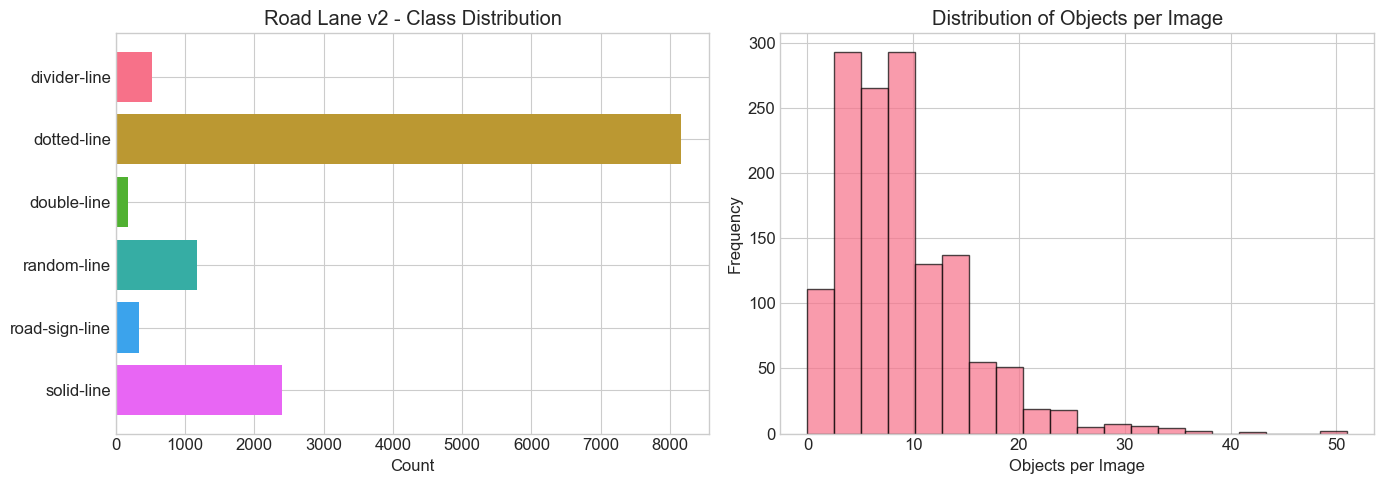

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_df = pd.DataFrame([
    {'Class': class_names[cid] if cid < len(class_names) else f"Class {cid}", 'Count': count}
    for cid, count in sorted(class_counts.items())
])
axes[0].barh(class_df['Class'], class_df['Count'], color=sns.color_palette('husl', len(class_df)))
axes[0].set_xlabel('Count')
axes[0].set_title('Road Lane v2 - Class Distribution')
axes[0].invert_yaxis()

# Objects per image histogram
axes[1].hist(objects_per_image, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Objects per Image')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Objects per Image')

plt.tight_layout()
plt.show()

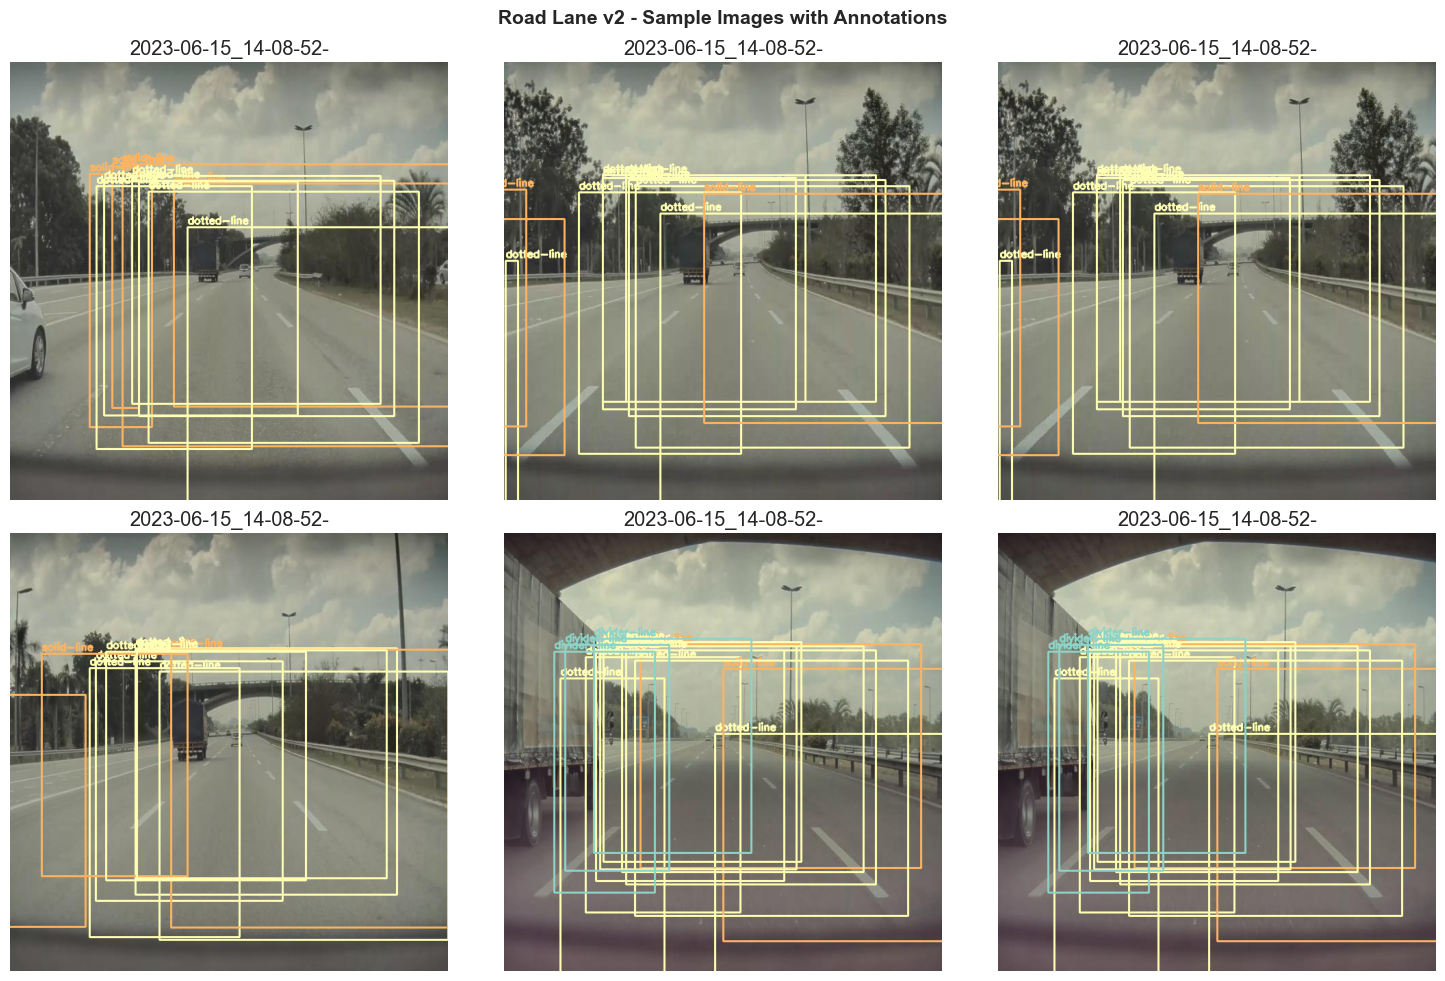

In [10]:
# Visualize sample images with annotations
def draw_yolo_boxes(img_path, label_path, class_names):
    """Draw YOLO bounding boxes on image."""
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    colors = plt.cm.Set3.colors
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center, y_center, box_w, box_h = map(float, parts[1:5])
                    
                    x1 = int((x_center - box_w / 2) * w)
                    y1 = int((y_center - box_h / 2) * h)
                    x2 = int((x_center + box_w / 2) * w)
                    y2 = int((y_center + box_h / 2) * h)
                    
                    color = tuple(int(c * 255) for c in colors[class_id % len(colors)][:3])
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    
                    label = class_names[class_id] if class_id < len(class_names) else f"C{class_id}"
                    cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return img

# Show sample images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sample_images = list((roboflow_path / 'train' / 'images').glob('*.jpg'))[60:67]
for ax, img_path in zip(axes, sample_images):
    label_path = roboflow_path / 'train' / 'labels' / (img_path.stem + '.txt')
    annotated = draw_yolo_boxes(img_path, label_path, class_names)
    ax.imshow(annotated)
    ax.set_title(img_path.name[:20])
    ax.axis('off')

plt.suptitle('Road Lane v2 - Sample Images with Annotations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## **BDD100K**

In [11]:
print("BDD100K Directory Structure:\n")

explore_directory(DATASETS['bdd100k'], max_depth=5)

BDD100K Directory Structure:

 bdd100k/ (0 files, 1 subdirs)
     images/ (0 files, 2 subdirs)
         100k/ (0 files, 3 subdirs)
             test/ (289 files, 4 subdirs)
                 testA/ (1180 files, 0 subdirs)
                 testB/ (790 files, 0 subdirs)
                 trainA/ (10632 files, 0 subdirs)
                 trainB/ (7109 files, 0 subdirs)
                 cb2fe290-8786cd14.jpg
                 cb8b28d3-ab96a5fc.jpg
                 cbed3fd1-314723c8.jpg
                 cc062302-f0e81d2a.jpg
                 cc289a8f-2bfa8b70.jpg
                ... and 284 more files
             train/ (1156 files, 4 subdirs)
                 testA/ (4130 files, 0 subdirs)
                 testB/ (2748 files, 0 subdirs)
                 trainA/ (37216 files, 0 subdirs)
                 trainB/ (24750 files, 0 subdirs)
                 002b485a-3f6603f2.jpg
                 003c4a61-52588960.jpg
                 0048f391-2c5344eb.jpg
                 0048f391-eae6a189.jpg
   

In [12]:
bdd_path = DATASETS['bdd100k']
json_files = list(bdd_path.rglob('*.json'))

print(f"Found {len(json_files)} JSON files:")
for jf in json_files:
    size_mb = jf.stat().st_size / (1024 * 1024)
    print(f"   {jf.relative_to(bdd_path)} ({size_mb:.1f} MB)")

Found 2 JSON files:
   bdd100k_labels_release\bdd100k\labels\bdd100k_labels_images_train.json (1384.0 MB)
   bdd100k_labels_release\bdd100k\labels\bdd100k_labels_images_val.json (198.6 MB)


In [13]:
all_categories = Counter()
all_attributes = defaultdict(Counter)
total_labels = 0
images_with_annotations = 0
sample_annotation = None

for json_file in json_files:
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        frames = data if isinstance(data, list) else [data]
        
        for frame in frames:
            if sample_annotation is None and frame.get('labels'):
                sample_annotation = frame
            
            labels = frame.get('labels', [])
            if labels:
                images_with_annotations += 1
            
            for label in labels:
                total_labels += 1
                category = label.get('category', 'unknown')
                all_categories[category] += 1
                
                # Collect attributes
                attrs = label.get('attributes', {})
                for key, value in attrs.items():
                    all_attributes[key][str(value)] += 1
                    
    except Exception as e:
        print(f"Error parsing {json_file}: {e}")

print(f"\nAnnotation Statistics:")
print(f"   Images with annotations: {images_with_annotations}")
print(f"   Total objects/labels: {total_labels:,}")
print(f"   Unique categories: {len(all_categories)}")


Annotation Statistics:
   Images with annotations: 79863
   Total objects/labels: 2,220,474
   Unique categories: 12


In [14]:
# Show sample annotation structure
if sample_annotation:
    print(f"Keys: {list(sample_annotation.keys())}")
    
    if 'labels' in sample_annotation and sample_annotation['labels']:
        print(f"\nSample label:")
        print(json.dumps(sample_annotation['labels'][0], indent=2))

Keys: ['name', 'attributes', 'timestamp', 'labels']

Sample label:
{
  "category": "traffic light",
  "attributes": {
    "occluded": false,
    "truncated": false,
    "trafficLightColor": "green"
  },
  "manualShape": true,
  "manualAttributes": true,
  "box2d": {
    "x1": 1125.902264,
    "y1": 133.184488,
    "x2": 1156.978645,
    "y2": 210.875445
  },
  "id": 0
}


     Category  Count
          car 815717
         lane 604373
 traffic sign 274594
traffic light 213002
drivable area 143704
       person 104611
        truck  34216
          bus  13269
         bike   8217
        rider   5166
        motor   3454
        train    151


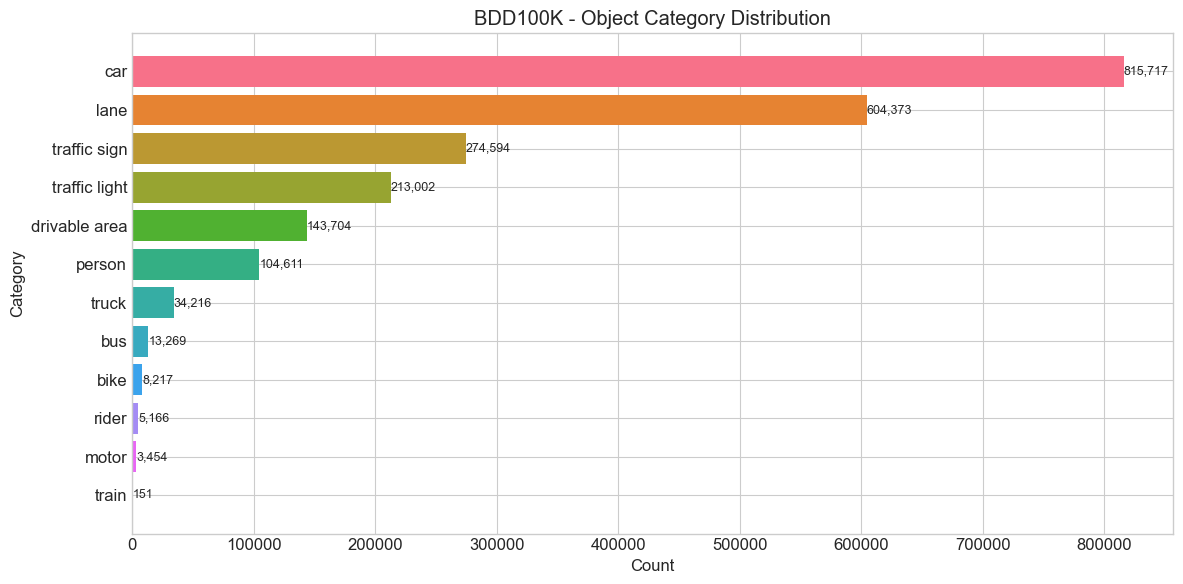

In [15]:
df_categories = pd.DataFrame(list(all_categories.items()), columns=['Category', 'Count'])
df_categories = df_categories.sort_values('Count', ascending=False)
print(df_categories.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(df_categories['Category'], df_categories['Count'], 
               color=sns.color_palette('husl', len(df_categories)))
ax.set_xlabel('Count')
ax.set_ylabel('Category')
ax.set_title('BDD100K - Object Category Distribution')
ax.invert_yaxis()

for bar, count in zip(bars, df_categories['Count']):
    ax.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [16]:
bdd_images = list(bdd_path.rglob('*.jpg')) + list(bdd_path.rglob('*.png'))
print(f"Total images found: {len(bdd_images):,}")

# Sample analysis
sample_size = min(100, len(bdd_images))
sample_imgs = np.random.choice(bdd_images, sample_size, replace=False) if bdd_images else []

image_info_bdd = [get_image_info(img) for img in sample_imgs]
df_bdd = pd.DataFrame([i for i in image_info_bdd if 'error' not in i])

if not df_bdd.empty:
    print(f"\nSample size: {len(df_bdd)} images")
    print(f"\nDimensions:")
    print(f"  Width:  min={df_bdd['width'].min()}, max={df_bdd['width'].max()}, mean={df_bdd['width'].mean():.0f}")
    print(f"  Height: min={df_bdd['height'].min()}, max={df_bdd['height'].max()}, mean={df_bdd['height'].mean():.0f}")
    print(f"\nFormats: {df_bdd['format'].value_counts().to_dict()}")
    print(f"Avg file size: {df_bdd['size_kb'].mean():.1f} KB")

Total images found: 110,000

Sample size: 100 images

Dimensions:
  Width:  min=1280, max=1280, mean=1280
  Height: min=720, max=720, mean=720

Formats: {'JPEG': 100}
Avg file size: 62.0 KB


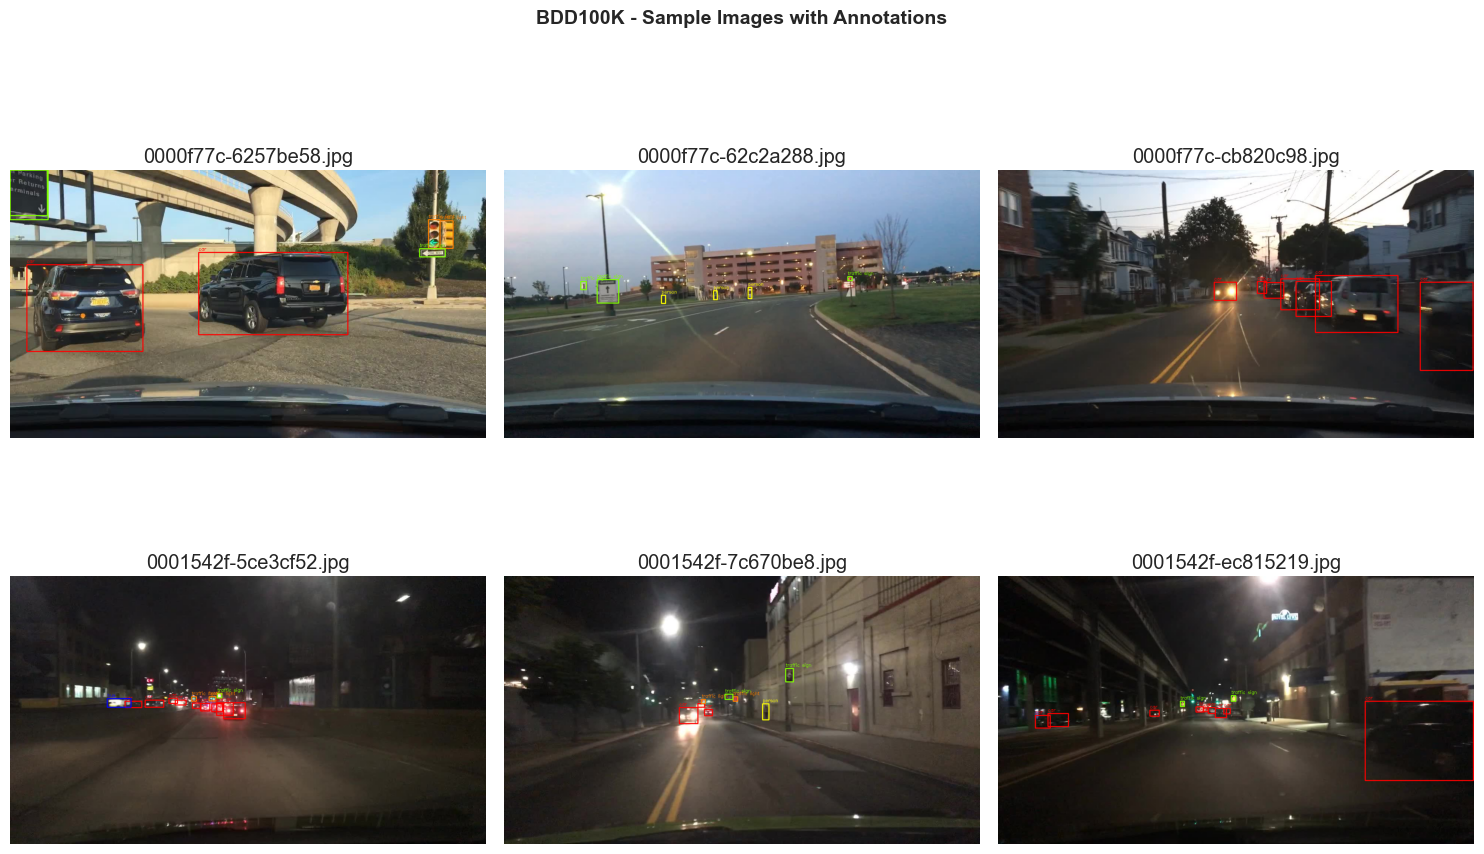

In [17]:
def draw_bdd100k_boxes(img_path, annotations):
    """Draw BDD100K bounding boxes on image."""
    img = cv2.imread(str(img_path))
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    colors = {
        'car': (255, 0, 0), 'truck': (0, 255, 0), 'bus': (0, 0, 255),
        'person': (255, 255, 0), 'bike': (255, 0, 255), 'motor': (0, 255, 255),
        'traffic light': (255, 128, 0), 'traffic sign': (128, 255, 0),
        'rider': (0, 128, 255), 'train': (128, 0, 255)
    }
    
    for label in annotations.get('labels', []):
        if 'box2d' in label:
            box = label['box2d']
            x1, y1 = int(box['x1']), int(box['y1'])
            x2, y2 = int(box['x2']), int(box['y2'])
            category = label.get('category', 'unknown')
            color = colors.get(category, (200, 200, 200))
            
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, category, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    
    return img

# Find images with annotations and display
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

shown = 0
for json_file in json_files:
    if shown >= 6:
        break
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
        frames = data if isinstance(data, list) else [data]
        
        for frame in frames[:10]:
            if shown >= 6:
                break
            img_name = frame.get('name', '')
            if not img_name or not frame.get('labels'):
                continue
            
            # Find image
            img_matches = list(bdd_path.rglob(img_name))
            if img_matches:
                annotated = draw_bdd100k_boxes(img_matches[0], frame)
                if annotated is not None:
                    axes[shown].imshow(annotated)
                    axes[shown].set_title(img_name[:25])
                    axes[shown].axis('off')
                    shown += 1
    except Exception as e:
        continue

plt.suptitle('BDD100K - Sample Images with Annotations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## **Convert to YOLO format**

In [18]:
CLASSES_TO_CONVERT = [
    'car', 'truck', 'bus', 'train',
    'person', 'rider', 'bike', 'motor',
    'traffic light', 'traffic sign', 'lane', 'drivable area'
]

In [19]:
def convert_box_to_yolo(box, img_width=1280, img_height=720):
    """
    Convert BDD100K box2d format to YOLO format.
    
    BDD100K: x1, y1, x2, y2 (pixel coordinates)
    YOLO: x_center, y_center, width, height (normalized 0-1)
    
    Args:
        box: dict with 'x1', 'y1', 'x2', 'y2' keys
        img_width: image width in pixels (default 1280 for BDD100K)
        img_height: image height in pixels (default 720 for BDD100K)
    
    Returns:
        tuple: (x_center, y_center, width, height) normalized to [0, 1]
    """
    x1, y1 = box['x1'], box['y1']
    x2, y2 = box['x2'], box['y2']
    
    # Calculate center and dimensions
    x_center = ((x1 + x2) / 2) / img_width
    y_center = ((y1 + y2) / 2) / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    
    # Clip to [0, 1] to handle edge cases
    x_center = max(0.0, min(1.0, x_center))
    y_center = max(0.0, min(1.0, y_center))
    width = max(0.0, min(1.0, width))
    height = max(0.0, min(1.0, height))
    
    return x_center, y_center, width, height

def convert_bdd100k_json_to_yolo(
    json_path: str,
    output_labels_dir: str,
    class_names: list = None,
    img_width: int = 1280,
    img_height: int = 720,
    verbose: bool = True
):
    """
    Convert a BDD100K JSON annotation file to YOLO format label files.
    
    Args:
        json_path: Path to BDD100K JSON annotation file
        output_labels_dir: Directory to save YOLO .txt label files
        class_names: List of class names to convert (order = class ID)
        img_width: Image width in pixels
        img_height: Image height in pixels
        verbose: Show progress bar
    
    Returns:
        dict: Statistics about the conversion
    """
    if class_names is None:
        class_names = CLASSES_TO_CONVERT
    
    # Create output directory
    os.makedirs(output_labels_dir, exist_ok=True)
    
    # Load JSON
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Handle both list and single object formats
    frames = data if isinstance(data, list) else [data]
    
    stats = {
        'total_frames': len(frames),
        'converted_images': 0,
        'skipped_images': 0,
        'total_objects': 0,
        'class_counts': Counter(),
        'skipped_categories': Counter()
    }
    
    iterator = tqdm(frames, desc="Converting") if verbose else frames
    
    for frame in iterator:
        img_name = frame.get('name', '')
        if not img_name:
            stats['skipped_images'] += 1
            continue
        
        labels = frame.get('labels', [])
        
        # Prepare YOLO format lines
        yolo_lines = []
        
        for label in labels:
            category = label.get('category', '')
            
            # Skip if category not in our class list
            if category not in class_names:
                stats['skipped_categories'][category] += 1
                continue
            
            # Skip if no bounding box
            if 'box2d' not in label:
                continue
            
            # Get class ID
            class_id = class_names.index(category)
            
            # Convert box to YOLO format
            box = label['box2d']
            x_center, y_center, width, height = convert_box_to_yolo(
                box, img_width, img_height
            )
            
            # Skip invalid boxes (too small or zero size)
            if width <= 0 or height <= 0:
                continue
            
            # Create YOLO format line
            yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
            yolo_lines.append(yolo_line)
            
            stats['class_counts'][category] += 1
            stats['total_objects'] += 1
        
        # Write label file (even if empty, for consistency)
        label_filename = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(output_labels_dir, label_filename)
        
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_lines))
        
        if yolo_lines:
            stats['converted_images'] += 1
        else:
            stats['skipped_images'] += 1
    
    return stats

def create_yolo_data_yaml(
    output_path: str,
    train_images_path: str,
    val_images_path: str,
    class_names: list,
    test_images_path: str = None
):
    """
    Create a YOLO data.yaml configuration file.
    
    Args:
        output_path: Path to save data.yaml
        train_images_path: Path to training images directory
        val_images_path: Path to validation images directory
        class_names: List of class names
        test_images_path: Optional path to test images directory
    """
    config = {
        'path': os.path.dirname(output_path),
        'train': train_images_path,
        'val': val_images_path,
        'nc': len(class_names),
        'names': class_names
    }
    
    if test_images_path:
        config['test'] = test_images_path
    
    with open(output_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False, sort_keys=False)
    
    print(f"Created: {output_path}")


In [20]:
BDD100K_DIR = BASE_DIR / 'bdd100k'

print(f"\nClasses to convert ({len(CLASSES_TO_CONVERT)}):")
for i, cls in enumerate(CLASSES_TO_CONVERT):
    print(f"   {i}: {cls}")

# Process each JSON file
all_stats = {'train': None, 'val': None}

for json_file in json_files:
    # Determine if train or val
    file_name = json_file.stem.lower()
    if 'train' in file_name:
        split = 'train'
    elif 'val' in file_name:
        split = 'val'
    else:
        print(f"\nSkipping {json_file.name} (unknown split)")
        continue
    
    print(f"\nConverting {split} set: {json_file.name}")
    
    output_labels_dir = BDD100K_DIR / 'yolo_labels' / split
    
    # Convert
    stats = convert_bdd100k_json_to_yolo(
        json_path=str(json_file),
        output_labels_dir=str(output_labels_dir),
        class_names=CLASSES_TO_CONVERT,
        verbose=True
    )
    
    all_stats[split] = stats
    
    print(f"\nConversion Statistics for {split}:")
    print(f"   Total frames: {stats['total_frames']:,}")
    print(f"   Images with objects: {stats['converted_images']:,}")
    print(f"   Images without objects: {stats['skipped_images']:,}")
    print(f"   Total objects converted: {stats['total_objects']:,}")
    
    print(f"\n   Class distribution:")
    for cls, count in stats['class_counts'].most_common():
        print(f"      {cls}: {count:,}")
    
    if stats['skipped_categories']:
        print(f"\n   Skipped categories (not in class list):")
        for cls, count in stats['skipped_categories'].most_common():
            print(f"      {cls}: {count:,}")
    
    print(f"\nLabels saved to: {output_labels_dir}")

yaml_path = BDD100K_DIR / 'data_yolo.yaml'

data_yaml_content = f"""
path: {BDD100K_DIR}
train: bdd100k/images/100k/train
val: bdd100k/images/100k/val

nc: {len(CLASSES_TO_CONVERT)}
names: {CLASSES_TO_CONVERT}
"""

with open(yaml_path, 'w') as f:
    f.write(data_yaml_content)

print(f"Created file .yaml: {yaml_path}")


Classes to convert (12):
   0: car
   1: truck
   2: bus
   3: train
   4: person
   5: rider
   6: bike
   7: motor
   8: traffic light
   9: traffic sign
   10: lane
   11: drivable area

Converting train set: bdd100k_labels_images_train.json


Converting: 100%|██████████| 69863/69863 [00:59<00:00, 1182.03it/s]



Conversion Statistics for train:
   Total frames: 69,863
   Images with objects: 69,863
   Images without objects: 0
   Total objects converted: 1,286,871

   Class distribution:
      car: 713,211
      traffic sign: 239,686
      traffic light: 186,117
      person: 91,349
      truck: 29,971
      bus: 11,672
      bike: 7,210
      rider: 4,517
      motor: 3,002
      train: 136

Labels saved to: d:\Learn\Kaggle Competition\Road-Buddy-Challenge\data\custom train data\bdd100k\yolo_labels\train

Converting val set: bdd100k_labels_images_val.json


Converting: 100%|██████████| 10000/10000 [00:07<00:00, 1276.07it/s]



Conversion Statistics for val:
   Total frames: 10,000
   Images with objects: 10,000
   Images without objects: 0
   Total objects converted: 185,526

   Class distribution:
      car: 102,506
      traffic sign: 34,908
      traffic light: 26,885
      person: 13,262
      truck: 4,245
      bus: 1,597
      bike: 1,007
      rider: 649
      motor: 452
      train: 15

Labels saved to: d:\Learn\Kaggle Competition\Road-Buddy-Challenge\data\custom train data\bdd100k\yolo_labels\val
Created file .yaml: d:\Learn\Kaggle Competition\Road-Buddy-Challenge\data\custom train data\bdd100k\data_yolo.yaml
